In [177]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [178]:
num_epochs = 10
batch_size = 1
learning_rate = 0.001

input_size = 222
sequence_length = 4
hidden_size = 128
num_layers = 2

In [179]:
initialize=True

In [180]:
df = pd.read_csv('../data/united_data.csv', index_col=0).fillna(0)
y = df['Corn_Yield']
X = df.drop(columns=['Corn_Yield'], axis=1)

In [127]:
y

2016-Nicollet County    209.4
2020-Nicollet County    205.9
2021-Nicollet County    209.5
2006-Nicollet County    180.0
2007-Nicollet County    145.0
                        ...  
2011-Rice County        158.3
2012-Rice County        186.1
2013-Rice County        168.5
2014-Rice County        157.1
2015-Rice County        201.1
Name: Corn_Yield, Length: 1172, dtype: float64

In [138]:
def transform(row):
    print(row.index)
    return row


In [139]:
y['year'] = y.index

In [143]:
y.apply(transform)

Index(['2016-Nicollet County', '2020-Nicollet County', '2021-Nicollet County',
       '2006-Nicollet County', '2007-Nicollet County', '2008-Nicollet County',
       '2009-Nicollet County', '2010-Nicollet County', '2011-Nicollet County',
       '2012-Nicollet County',
       ...
       '2007-Rice County', '2008-Rice County', '2009-Rice County',
       '2010-Rice County', '2011-Rice County', '2012-Rice County',
       '2013-Rice County', '2014-Rice County', '2015-Rice County', 'year'],
      dtype='object', length=1173)
Index(['2016-Nicollet County', '2020-Nicollet County', '2021-Nicollet County',
       '2006-Nicollet County', '2007-Nicollet County', '2008-Nicollet County',
       '2009-Nicollet County', '2010-Nicollet County', '2011-Nicollet County',
       '2012-Nicollet County',
       ...
       '2007-Rice County', '2008-Rice County', '2009-Rice County',
       '2010-Rice County', '2011-Rice County', '2012-Rice County',
       '2013-Rice County', '2014-Rice County', '2015-Rice Count

,Corn_Yield,year
2016-Nicollet County,209.4,2016-Nicollet County
2020-Nicollet County,205.9,2020-Nicollet County
2021-Nicollet County,209.5,2021-Nicollet County
2006-Nicollet County,180.0,2006-Nicollet County
2007-Nicollet County,145.0,2007-Nicollet County
...,...,...
2012-Rice County,186.1,2012-Rice County
2013-Rice County,168.5,2013-Rice County
2014-Rice County,157.1,2014-Rice County
2015-Rice County,201.1,2015-Rice County


In [181]:
class MyDataset(Dataset):
 
  def __init__(self,X,y):
    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [183]:
train_data=MyDataset(X_train.to_numpy(), y_train.to_numpy())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=False)

test_data=MyDataset(X_test.to_numpy(), y_test.to_numpy())
train_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [184]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)


In [185]:
X_test.shape

torch.Size([363, 888])

In [223]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        if initialize:
            h0 = torch.zeros(num_layers, x.size(0), hidden_size)
            c0 = torch.zeros(num_layers, x.size(0), hidden_size)
            x, _ = self.lstm(x,(h0,c0))
        else:
            x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [224]:
model = LSTM(input_size, hidden_size, num_layers)

In [225]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (weather, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        weather = weather.reshape(-1, sequence_length, input_size)
        
        # Forward pass
        outputs = model(weather)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

C:\Morgan Stanley\quant-challenge\venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Step [100/363], Loss: 24117.9863
Epoch [1/10], Step [200/363], Loss: 13647.4414
Epoch [1/10], Step [300/363], Loss: 2036.1176
Epoch [2/10], Step [100/363], Loss: 13508.5449
Epoch [2/10], Step [200/363], Loss: 6579.9424
Epoch [2/10], Step [300/363], Loss: 153.6656
Epoch [3/10], Step [100/363], Loss: 7725.9702
Epoch [3/10], Step [200/363], Loss: 3057.9731
Epoch [3/10], Step [300/363], Loss: 120.4891
Epoch [4/10], Step [100/363], Loss: 4671.5605
Epoch [4/10], Step [200/363], Loss: 1435.3717
Epoch [4/10], Step [300/363], Loss: 694.8549
Epoch [5/10], Step [100/363], Loss: 3141.2478
Epoch [5/10], Step [200/363], Loss: 740.5954
Epoch [5/10], Step [300/363], Loss: 1263.2213
Epoch [6/10], Step [100/363], Loss: 3348.2715
Epoch [6/10], Step [200/363], Loss: 817.6248
Epoch [6/10], Step [300/363], Loss: 1991.7379
Epoch [7/10], Step [100/363], Loss: 1437.6393
Epoch [7/10], Step [200/363], Loss: 120.4193
Epoch [7/10], Step [300/363], Loss: 2749.5042
Epoch [8/10], Step [100/363], Loss: 9

In [211]:
weather = X_test.reshape(-1, sequence_length, input_size)
print(weather.shape)
labels = y_test
outputs = model(weather)
loss = criterion(outputs.reshape(-1), labels)
loss

torch.Size([363, 4, 222])
tensor([[[ -9.7000, -20.0000,  -3.9000,  ...,   0.8000,  -0.6000,  -1.7000],
         [  0.0000,  15.7000,   0.8000,  ...,  -3.9000,  20.0000,   0.0000],
         [ 13.9000,   7.2000,  21.1000,  ...,  38.9000,  16.3000,  10.0000],
         [ 21.1000,   0.0000,  16.3000,  ...,  -1.7000,  18.9000,   0.0000]],

        [[ -5.9000, -12.0000,  -1.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   6.3000,  ...,   7.0000,  10.0000,   0.0000],
         [  8.5000,   4.0000,  14.0000,  ...,   0.0000,  25.3000,  20.0000],
         [ 31.0000,   0.0000,   0.0000,  ...,   5.0000,  18.0000,   0.0000]],

        [[ -4.7000,  -8.3000,  -1.1000,  ...,   0.0000,  -4.7000,  -9.4000],
         [  0.0000,   0.0000,  -0.8500,  ...,   3.3000,  11.1000,   0.0000],
         [  1.6500,  -0.6000,   3.9000,  ...,   0.3000,  22.5000,  17.2000],
         [ 27.8000,  12.7000,  21.4000,  ...,   1.7000,  23.3000,   0.0000]],

        ...,

        [[ -6.9400, -14.7800, 

tensor(911.1342, grad_fn=<MseLossBackward0>)

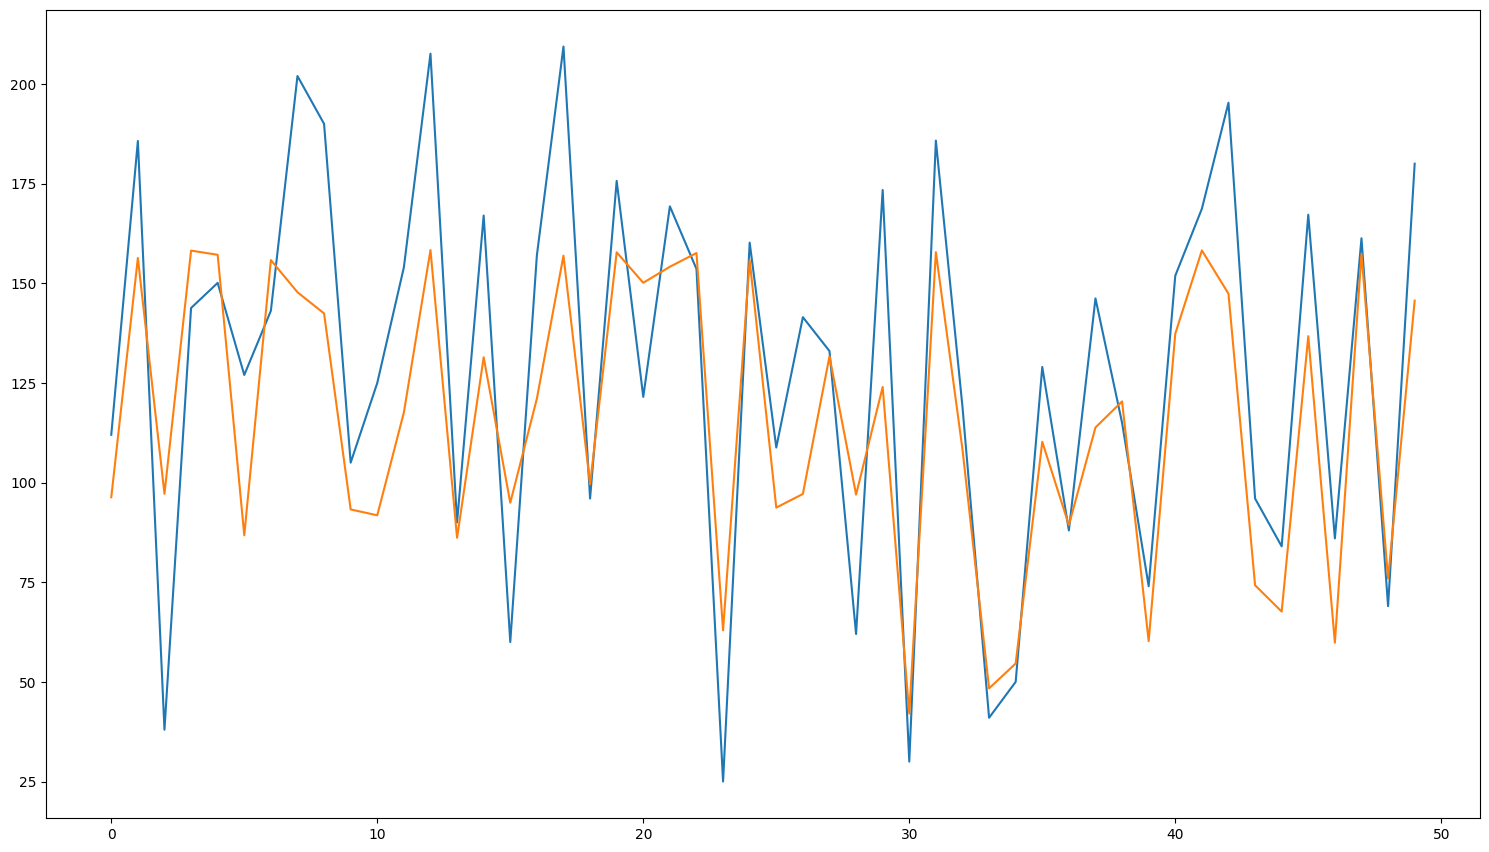

In [216]:
plt.plot(y_test[:50])
plt.plot(outputs[:50].detach())
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [213]:
# torch.save(model.state_dict(), "lstm_1000_2_128")

In [214]:
from utils import get_data_pred

In [220]:
weather = get_data_pred('ACAvNTuEuFWcmwms').fillna(0)
weather = torch.tensor(weather.to_numpy(), dtype=torch.float32)
weather = weather.reshape(-1, sequence_length, input_size)

In [221]:
outputs = model(weather)

tensor([[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   4.0200,   0.7700],
         [  5.8900,   0.0000,   3.3700,  ...,   5.0100,   5.7600,   0.0000],
         [  7.0000,   5.3100,   8.3100,  ...,   0.0000,  25.3400,  14.9500],
         [ 34.5200,   0.0000,  26.3000,  ...,   4.7500,  16.5600,   0.5700]],

        [[ -0.2400,  -5.1600,   2.7300,  ...,   0.0000,  -6.8900, -16.6700],
         [  1.5500,   0.0000,   5.3500,  ...,   6.8200,  17.5800,   0.0000],
         [ 13.3900,   5.9600,  19.7000,  ...,   0.0000,  15.9400,   8.3100],
         [ 21.3900,   0.0000,  14.5500,  ...,  16.4200,  21.5500,   0.0000]],

        [[-13.3200, -18.7100,  -5.9600,  ...,   0.0000, -14.4200, -28.7700],
         [ -4.8300,   0.0000,   0.0000,  ...,   2.8200,  11.2100,   0.0000],
         [  6.6100,   0.1400,  17.7500,  ...,   0.0000,  21.6400,  14.4800],
         [ 25.0700,   1.0200,  20.2900,  ...,   4.2600,  13.6100,   0.0000]],

        ...,

        [[ -9.5700, -14.3500,   1.6200,  ...,   0.0000, 

In [222]:
outputs

tensor([[100.2934],
        [ 96.1967],
        [ 95.1817],
        [112.0884],
        [ 98.1280],
        [ 88.9596],
        [156.1279],
        [137.4307],
        [ 74.4149],
        [108.9806],
        [119.3128],
        [126.0991],
        [127.9114],
        [104.2989],
        [106.2627],
        [154.4127],
        [ 77.3407]], grad_fn=<AddmmBackward0>)

In [218]:
weather.shape

torch.Size([17, 4, 222])